<a href="https://colab.research.google.com/github/omarlura/GCP/blob/main/EDA_V1_sustentado.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Proyecto Avanza - Modelo de probabilidad de default créditos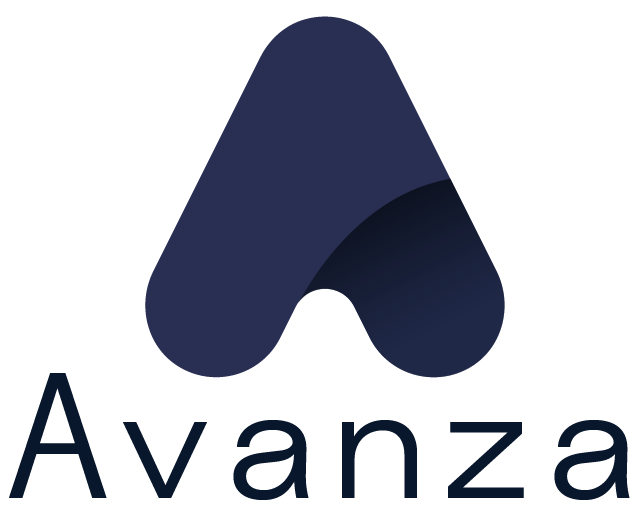

In [ ]:
#En esta Celda se dejan comentariadas las librerias que fue necesario instalar por no estar disponibles en la plataforma
#!pip install ydata_profiling

# 1. Importación de librerías requeridas

- **Seaborn (`sns`)**: Biblioteca de visualización basada en Matplotlib que facilita la creación de gráficos estadísticos atractivos y con estilo predefinido. Se utiliza para analizar patrones y relaciones en los datos.

- **Pandas (`pd`)**: Librería fundamental para manipulación y análisis de datos en Python. Proporciona estructuras de datos como DataFrames y Series para gestionar datos tabulares de manera eficiente.

- **NumPy (`np`)**: Biblioteca para cálculo numérico que permite realizar operaciones matemáticas avanzadas, manipulación de matrices y funciones estadísticas esenciales en el análisis de datos.

- **Matplotlib (`plt`)**: Herramienta de visualización que permite generar gráficos como histogramas, dispersión y boxplots, proporcionando control detallado sobre los elementos visuales.

- **BigQuery (`bigquery`)**: Cliente de Google Cloud que permite ejecutar consultas SQL en bases de datos de BigQuery, facilitando la extracción y análisis de grandes volúmenes de datos almacenados en la nube.

In [ ]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google.cloud import bigquery
bq = bigquery.Client()

# Introducción

El Análisis Exploratorio de Datos (EDA) tiene como objetivo examinar la estructura y calidad de los datos extraídos desde BigQuery.

# 2. Carga de datos
La extracción de datos se realizó mediante una consulta SQL en BigQuery, accediendo al proyecto 'avanza-369421' y seleccionando las siguientes variables:

**Propios de las fuentes**

- credit_id
- request_amount
- is_phone_verified
- name
- value
- status
- name
- experian_ore
- expirian_credit_behaviour
- expirian_identification_ate
- demographic_point
- maximum_fee
- study_state_information
- liabilities
- pass_borrowing_capacity
- assets
- pass_unpaid_time_la_year
- monthly_income
- pass_maximum_fee_capacity
- monthly_expenses
- pa_investment_capacity
- pa_expirian_score
- ingreso_valor
- pass_demographic_score
- pass_expirian_credit_behaviour
- quanto
- adjusted_maximum_fee_capacity
- credit_credit_id
- initial_income_data_entered
- points
- name
- quantity
- name
- reference
- price
- cylinder_capacity
- name

**Campos calculados **

- T1.tuvo_mora
- T1.cuotas_en_mora
- T1.en_mora
- T1.cartera_menor_30
- T1.cartera_30_60
- T1.cartera_60_90
- T1.cartera_mayor_90
- T2.pagos_digitales
- T2.pagos_fisicos
- T1.inicio_cuotas
- T1.inicio_cuotas
- T1.inicio_cuotas

In [ ]:
import bigframes.pandas as bf

bf.options.bigquery.location = "US" #this variable is set based on the dataset you chose to query
bf.options.bigquery.project = "avanza-369421" #this variable is set based on the dataset you chose to query

In [ ]:
sql_dataset = """SELECT c.credit_id, CAST(c.request_amount AS FLOAT64) request_amount, b.is_phone_verified, z.name AS country_name, g.value AS gender, m.status AS marital_status,
                 DATE_DIFF(c.creation_date, born_Date, YEAR) - CASE WHEN EXTRACT(MONTH FROM c.creation_date) < EXTRACT(MONTH FROM born_Date) OR
                 (EXTRACT(MONTH FROM c.creation_date) = EXTRACT(MONTH FROM born_Date) AND EXTRACT(DAY FROM c.creation_date) < EXTRACT(DAY FROM born_Date))
                 THEN 1
                 ELSE 0 END AS age,
                 y.name AS city_name, s.experian_score, s.expirian_credit_behaviour, s.expirian_identification_state, s.demographic_points, CAST(s.maximum_fee AS FLOAT64) maximum_fee,
                 s.study_state_information, CAST(s.liabilities AS FLOAT64) liabilities, COALESCE(s.pass_borrowing_capacity,0) pass_borrowing_capacity, CAST(s.assets AS FLOAT64) assets, s.pass_unpaid_time_last_year, CAST(s.monthly_income AS FLOAT64) AS monthly_income, s.pass_maximum_fee_capacity,
                 CAST(s.monthly_expenses AS FLOAT64) monthly_expenses, s.pass_investment_capacity, s.pass_expirian_score, CAST(s.ingreso_valor AS FLOAT64) ingreso_valor, s.pass_demographic_score, s.pass_expirian_credit_behaviour, s.quanto,
                 s.adjusted_maximum_fee_capacity, COUNT(DISTINCT s.study_id) n_estudios, s.credit_credit_id, CAST(s.initial_income_data_entered AS FLOAT64) initial_income_data_entered, m.points AS points_marital_status,
                 e.name AS credit_state_name, d.quantity AS due, p.name AS product_name, p.reference AS product_reference, CAST(p.price AS FLOAT64) AS product_price, p.cylinder_capacity AS product_cylinder_capacity,
                 x.name AS name_product_line, T1.tuvo_mora AS tuvo_mora, T1.cuotas_en_mora AS cuotas_en_mora,T1.inicio_cuotas, T1.en_mora AS en_mora, T1.cartera_menor_30 AS cartera_menor_30_dias,
                 T1.cartera_30_60 AS cartera_30_60_dias, T1.cartera_60_90 AS cartera_60_90_dias, T1.cartera_mayor_90 AS cartera_mayor_90_dias, COALESCE(T2.pagos_digitales,0) AS pagos_digitales,
                COALESCE(T2.pagos_fisicos,0) AS pagos_fisicos,
                COALESCE(T3.Registros,0) AS n_otras_solicitudes
FROM `avanza-369421.creditos.avanza_prd_credit` c
LEFT JOIN `avanza-369421.creditos.avanza_prd_study` s
    ON c.credit_id = s.credit_credit_id
INNER JOIN `avanza-369421.creditos.avanza_prd_credit_state` e
    ON e.credit_state_id = c.credit_state_id
INNER JOIN `avanza-369421.creditos.avanza_prd_borrower` b
    ON c.borrower_borrower_id = b.borrower_id
INNER JOIN `avanza-369421.creditos.avanza_prd_product` p
    ON c.product_product_id = p.product_id
INNER JOIN `avanza-369421.creditos.avanza_prd_credit_supplier_state` a
    ON c.credit_supplier_state_credit_supplier_state_id = a.credit_supplier_state_id
INNER JOIN `avanza-369421.creditos.avanza_prd_due` d
    ON c.due_id = d.due_id
LEFT JOIN `avanza-369421.creditos.avanza_prd_parameter` f
    ON c.credit_id = f.credit_credit_id
INNER JOIN `avanza-369421.creditos.avanza_prd_gender` g
    ON b.gender_id = g.gender_id
INNER JOIN `avanza-369421.creditos.avanza_prd_marital_status` m
    ON b.marital_status_id = m.marital_status_id
LEFT JOIN `avanza-369421.creditos.avanza_prd_country` z
    ON b.country_country_id = z.country_id
INNER JOIN `avanza-369421.creditos.avanza_prd_city` y
    ON b.city_city_id = y.city_id
LEFT JOIN `avanza-369421.creditos.avanza_prd_line` x
    ON p.line_line_id = x.line_id
LEFT JOIN `avanza-369421.creditos.avanza_prd_parameter` pr
    ON c.credit_id = pr.credit_credit_id
LEFT JOIN (
    SELECT
        parameter_parameter_id,
        MIN(expiration_date) AS inicio_cuotas,
        SUM(CASE WHEN total_days_past_due > 0 OR T.state <> 'R' THEN 1 ELSE 0 END) AS tuvo_mora,
        SUM(CASE WHEN state <> 'R' AND expiration_date <= CURRENT_DATE() THEN 1 ELSE 0 END) AS cuotas_en_mora,
        MAX(CASE WHEN state <> 'R' AND expiration_date <= CURRENT_DATE() THEN 1 ELSE 0 END) AS en_mora,
        SUM(CASE WHEN total_days_past_due BETWEEN 0 AND 30 AND state <> 'R' AND expiration_date <= CURRENT_DATE() THEN 1 ELSE 0 END) AS cartera_menor_30,
        SUM(CASE WHEN total_days_past_due BETWEEN 31 AND 60 AND state <> 'R' AND expiration_date <= CURRENT_DATE() THEN 1 ELSE 0 END) AS cartera_30_60,
        SUM(CASE WHEN total_days_past_due BETWEEN 61 AND 90 AND state <> 'R' AND expiration_date <= CURRENT_DATE() THEN 1 ELSE 0 END) AS cartera_60_90,
        SUM(CASE WHEN total_days_past_due > 90 AND state <> 'R' AND expiration_date <= CURRENT_DATE() THEN 1 ELSE 0 END) AS cartera_mayor_90
    FROM (
        SELECT
            parameter_parameter_id,
            expiration_date,
            SUM(days_past_due) AS total_days_past_due,
            MAX(state) AS state
        FROM `avanza-369421.creditos.avanza_prd_collection_rsn`
        WHERE FORMAT_DATE('%Y-%m', expiration_date) <= FORMAT_DATE('%Y-%m', CURRENT_DATE()) --expiration_date <= CURRENT_DATE()
        GROUP BY parameter_parameter_id, expiration_date
    ) T
    GROUP BY parameter_parameter_id
) T1
ON pr.parameter_id = T1.parameter_parameter_id
LEFT JOIN (
    SELECT
        P.credit_credit_id,
        P.parameter_id,
        SUM(CASE WHEN N.number_fee IS NULL THEN 0 ELSE 1 END) AS pagos_digitales,
        SUM(CASE WHEN N.number_fee IS NULL THEN 1 ELSE 0 END) AS pagos_fisicos
    FROM `avanza-369421.creditos.avanza_prd_parameter` P
    INNER JOIN `avanza-369421.creditos.avanza_prd_collection_rsn` R
        ON P.parameter_id = R.parameter_parameter_id
        AND R.state = 'R'
    LEFT JOIN `avanza-369421.creditos.avanza_prd_webhook_notification` N
        ON N.credit_credit_id = P.credit_credit_id
        AND N.number_fee = R.fee
        AND N.transaction_result = 'PAID'
    GROUP BY P.credit_credit_id, P.parameter_id
) T2
ON pr.parameter_id = T2.parameter_id
LEFT JOIN (
    SELECT      C.borrower_borrower_id,
                S.name EstadoCredito,
                COUNT(DISTINCT C.credit_id) registros
    FROM        `creditos.avanza_prd_credit` C
    INNER JOIN  `creditos.avanza_prd_credit_state` S
    ON          C.credit_state_id = S.credit_state_id
    WHERE       C.credit_state_id <> 4
    GROUP BY    C.borrower_borrower_id, S.name
) T3
on  T3.borrower_borrower_id = c.borrower_borrower_id
WHERE c.credit_state_id = 4 AND T1.inicio_cuotas is not null --and c.credit_id = 2901
GROUP BY
    c.credit_id,
    c.request_amount,
    b.is_phone_verified,
    z.name,
    g.value,
    m.status,
    y.name,
    s.experian_score,
    s.expirian_credit_behaviour,
    s.expirian_identification_state,
    s.demographic_points,
    s.maximum_fee,
    s.study_state_information,
    s.liabilities,
    s.pass_borrowing_capacity,
    s.assets,
    s.pass_unpaid_time_last_year,
    s.monthly_income,
    s.pass_maximum_fee_capacity,
    s.monthly_expenses,
    s.pass_investment_capacity,
    s.pass_expirian_score,
    s.ingreso_valor,
    s.pass_demographic_score,
    s.pass_expirian_credit_behaviour,
    s.quanto,
    s.adjusted_maximum_fee_capacity,
    s.credit_credit_id,
    s.initial_income_data_entered,
    m.points,
    e.name,
    d.quantity,
    p.name,
    p.reference,
    p.price,
    p.cylinder_capacity,
    x.name,
    T1.tuvo_mora,
    T1.cuotas_en_mora,
    T1.en_mora,
    T1.cartera_menor_30,
    T1.cartera_30_60,
    T1.cartera_60_90,
    T1.cartera_mayor_90,
    T2.pagos_digitales,
    T2.pagos_fisicos,
    T1.inicio_cuotas,
    DATE_DIFF(c.creation_date, born_Date, YEAR) - CASE WHEN EXTRACT(MONTH FROM c.creation_date) < EXTRACT(MONTH FROM born_Date) OR
             (EXTRACT(MONTH FROM c.creation_date) = EXTRACT(MONTH FROM born_Date) AND EXTRACT(DAY FROM c.creation_date) < EXTRACT(DAY FROM born_Date))
              THEN 1
              ELSE 0 END,
    T3.Registros
ORDER BY c.credit_id"""

In [ ]:
df = bf.read_gbq(sql_dataset) #this variable is set based on the dataset you chose to query

# 3. Análisis Exploratorio de datos (EDA)

# 3.1 Exploracion univariada
* Carga del query en un dataframe
* Dimensiones del dataframe para validar
cantidad de filas y columnas
* Visibilidad de los datos, identificando valores nulos y tipos de datos del dataframe
* Resumen estadistico de las columnas numéricas.
*  Conversión de 'request_amount' a tipo FLOAT64
* Eliminación o imputación de valores nulos en variables clave.
* Verificación de la consistencia de datos

In [ ]:
df.shape

(2575, 50)

In [ ]:
# BigFrames can work with tables that are too large to fit in the notebook memory.
# Look at the first 20 rows.
df.head(10)

,credit_id,request_amount,is_phone_verified,country_name,gender,marital_status,age,city_name,experian_score,expirian_credit_behaviour,...,cuotas_en_mora,inicio_cuotas,en_mora,cartera_menor_30_dias,cartera_30_60_dias,cartera_60_90_dias,cartera_mayor_90_dias,pagos_digitales,pagos_fisicos,n_otras_solicitudes
0,21010,6792000.0,1,COLOMBIA,HOMBRE,SOLTERO,51,Bogotá,744,NN,...,0,2024-08-24,0,0,0,0,0,4,2,0
1,3387,11899000.0,1,COLOMBIA,HOMBRE,SOLTERO,25,Bogotá,724,,...,2,2023-12-17,1,1,1,0,0,0,13,0
2,32890,10724250.0,1,COLOMBIA,MUJER,SOLTERO,40,Bogotá,766,,...,0,2024-12-22,0,0,0,0,0,0,2,0
3,28696,14719200.0,1,COLOMBIA,HOMBRE,SOLTERO,22,Chia,778,,...,0,2024-11-15,0,0,0,0,0,0,4,0
4,10146,9000000.0,1,COLOMBIA,MUJER,SOLTERO,22,Bogotá,777,,...,0,2024-04-26,0,0,0,0,0,6,4,0
5,11425,8924150.0,1,COLOMBIA,HOMBRE,SOLTERO,39,Bogotá,846,NN-NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN-NNNNNNN...,...,0,2024-04-21,0,0,0,0,0,0,10,0
6,18099,7519200.0,1,COLOMBIA,HOMBRE,SOLTERO,30,Bogotá,768,,...,0,2024-07-18,0,0,0,0,0,2,6,0
7,23466,8990000.0,1,COLOMBIA,HOMBRE,SOLTERO,29,Bogotá,700,NNNNNNNNN,...,2,2024-10-10,1,1,1,0,0,3,0,0
8,36731,11153220.0,1,COLOMBIA,HOMBRE,SOLTERO,22,Bogotá,777,,...,0,2025-02-10,0,0,0,0,0,1,0,0
9,12805,9699000.0,1,COLOMBIA,HOMBRE,SOLTERO,28,Bogotá,737,,...,1,2024-05-12,1,1,0,0,0,0,9,0


- Se revisan lso tipos de dato y completitud de cada una de las variables

In [ ]:
df.info()

<class 'bigframes.dataframe.DataFrame'>


Index: 2575 entries, 0 to 2574
Data columns (total 50 columns):


/usr/local/lib/python3.10/dist-packages/bigframes/core/blocks.py:140: NullIndexPreviewWarning: Creating object with Null Index. Null Index is a preview feature.
  warnings.warn(


  #  Column                          Non-Null Count    Dtype
---  ------------------------------  ----------------  --------------------
  0  credit_id                       2575 non-null     Int64
  1  request_amount                  2575 non-null     Float64
  2  is_phone_verified               2575 non-null     Int64
  3  country_name                    2575 non-null     string
  4  gender                          2575 non-null     string
  5  marital_status                  2575 non-null     string
  6  age                             2575 non-null     Int64
  7  city_name                       2575 non-null     string
  8  experian_score                  2575 non-null     Int64
  9  expirian_credit_behaviour       2575 non-null     string
 10  expirian_identification_state   2575 non-null     string
 11  demographic_points              885 non-null      Int64
 12  maximum_fee                     2575 non-null     Float64
 13  study_state_information         2575 non-null     strin

# 4. Análisis Estadístico

Se calcularon estadísticas descriptivas como media, mediana, desviación estándar y distribución de datos clave.


In [ ]:
df.describe()

,credit_id,request_amount,is_phone_verified,age,experian_score,demographic_points,maximum_fee,liabilities,pass_borrowing_capacity,assets,...,cuotas_en_mora,inicio_cuotas,en_mora,cartera_menor_30_dias,cartera_30_60_dias,cartera_60_90_dias,cartera_mayor_90_dias,pagos_digitales,pagos_fisicos,n_otras_solicitudes
count,2575.0,2575.0,2575.0,2575.0,2575.0,885.0,2575.0,885.0,2575.0,885.0,...,2575.0,2575,2575.0,2575.0,2575.0,2575.0,2575.0,2575.0,2575.0,2575.0
mean,19097.756893,9796394.654369,1.0,31.69165,758.708738,40.259887,797836.122718,283468.538983,0.343689,59438655.367232,...,1.088155,<NA>,0.373592,0.494369,0.16466,0.112621,0.316505,1.44,9.555728,0.11301
std,11179.01873,2989322.874839,0.0,10.560794,39.92591,2.793461,309964.052713,3288030.862707,0.475031,67492412.257454,...,2.357928,<NA>,0.483851,0.868527,0.370946,0.316191,1.348263,1.906974,16.817958,0.349333
min,72.0,1760000.0,1.0,19.0,650.0,32.0,128004.0,1.0,0.0,100000.0,...,0.0,<NA>,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,9328.0,7801170.0,1.0,23.0,729.0,38.0,598000.0,1.0,0.0,20000000.0,...,0.0,<NA>,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50%,19745.0,9999000.0,1.0,28.0,755.0,41.0,755300.0,50000.0,0.0,38000000.0,...,0.0,<NA>,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0
75%,28345.0,11899000.0,1.0,37.0,784.0,42.0,936700.0,100000.0,1.0,68000000.0,...,1.0,<NA>,1.0,1.0,0.0,0.0,0.0,3.0,10.0,0.0
max,39886.0,20699000.0,1.0,68.0,905.0,47.0,3736050.0,96000000.0,1.0,600000000.0,...,18.0,<NA>,1.0,6.0,1.0,1.0,15.0,8.0,203.0,3.0


In [ ]:
df1 = df.to_pandas()

# Libreria para revisar datos faltantes de manera visual

1. **`missingno (msno)`**: Visualiza y analiza valores faltantes en un DataFrame de pandas, utilizando gráficos interactivos.

2. **`datetime`**: Trabaja con fechas y horas en Python, permitiendo su creación, manipulación y formato.

3. **`relativedelta`**: Realiza operaciones de fechas más complejas (sumar/restar meses, años, etc.), extendiendo la funcionalidad de `datetime`.

4. **`SQLAlchemyError`**: Maneja excepciones y errores relacionados con las operaciones en bases de datos usando SQLAlchemy.

5. **`pyarrow (pa)`**: Permite trabajar con el formato de datos Apache Arrow, facilitando la lectura y escritura de archivos Parquet y la manipulación de tablas Arrow.

6. **`is_integer_dtype, is_float_dtype`**: Verifica si las columnas de un DataFrame tienen tipos de datos enteros o de punto flotante, respectivamente.

7. **`%matplotlib inline`**: Muestra gráficos generados por `matplotlib` directamente en un cuaderno Jupyter, dentro de la celda.

In [ ]:
import missingno as msno
import datetime
from dateutil.relativedelta import relativedelta
from sqlalchemy.exc import SQLAlchemyError
import pyarrow as pa
from pandas.api.types import is_integer_dtype, is_float_dtype
%matplotlib inline


- Esta representación gráfica muestra de manera clara qué valores están presentes y cuáles están ausentes en el DataFrame

<Axes: >

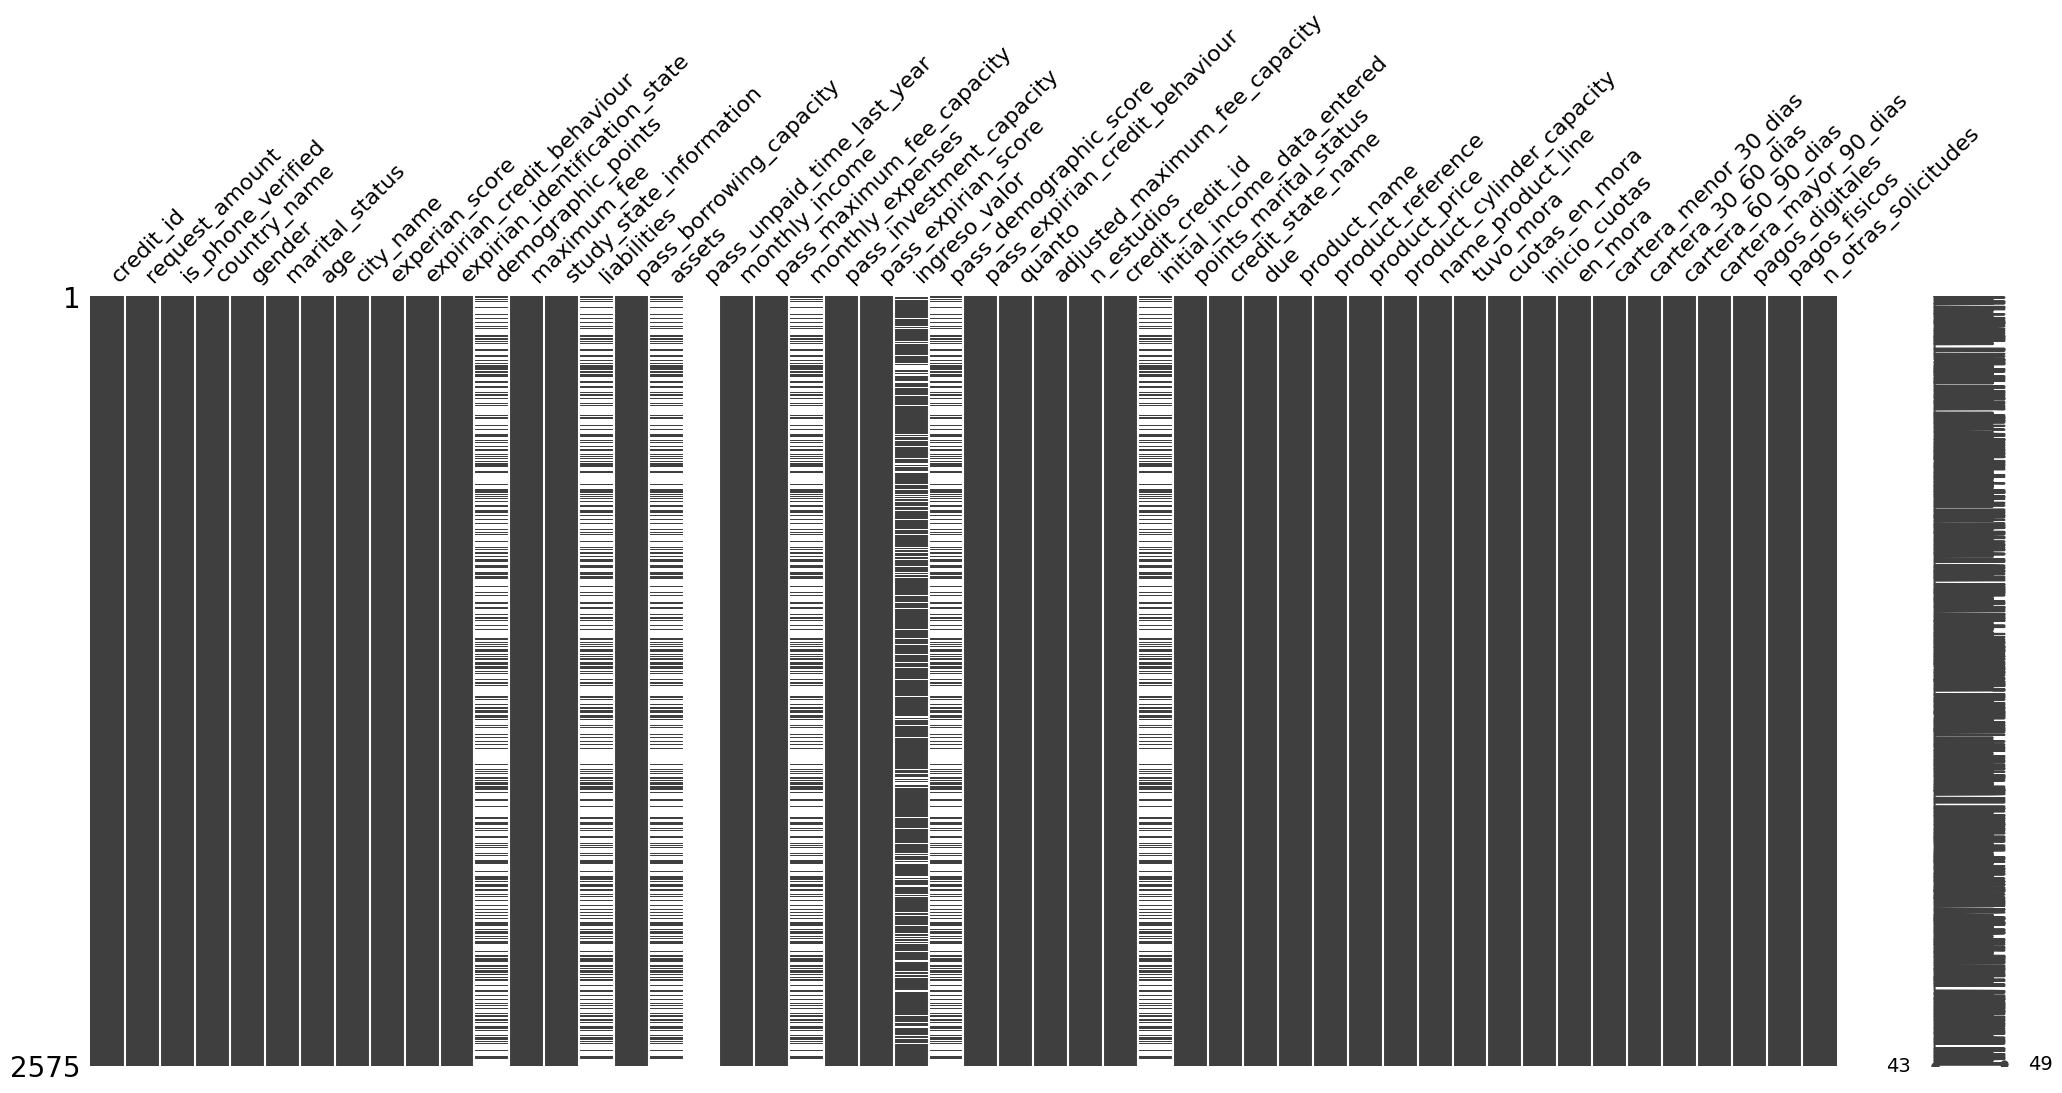

In [ ]:
msno.matrix(df1)

- Con el siguiente scritp buscamos identificar las columnas de un DataFrame (df1) que tienen un porcentaje de valores nulos superior a un umbral específico, en este caso el 40%

In [ ]:
umbral = 0.4
nulos = df1.isnull().mean()
nulos[nulos >= umbral]

,0
demographic_points,0.656311
liabilities,0.656311
assets,0.656311
pass_unpaid_time_last_year,1.000000
monthly_expenses,0.656311
pass_demographic_score,0.656311
initial_income_data_entered,0.656311


- Procedemos a filtrar y mantener solo las columnas de un DataFrame (df1) que tienen menos del 40% de valores nulos, según el umbral definido previamente

In [ ]:
columnas_mantener = nulos[nulos < umbral].index
df = df1[columnas_mantener]

-  Aqui se reemplaza los valores nulos (NaN) en la columna 'ingreso_valor' del DataFrame df con la mediana de los valores no nulos de esa misma columna.

In [ ]:
# Asignar la media de 'ingreso_valor' a los registros nulos
df.fillna({'ingreso_valor': df['ingreso_valor'].median()}, inplace=True)
#df.fillna({'ingreso_valor': 0}, inplace=True)

<ipython-input-14-514b027f4715>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.fillna({'ingreso_valor': df['ingreso_valor'].median()}, inplace=True)


- Nuevamente buscamos validar graficamente qué valores están presentes y cuáles están ausentes en el DataFrame

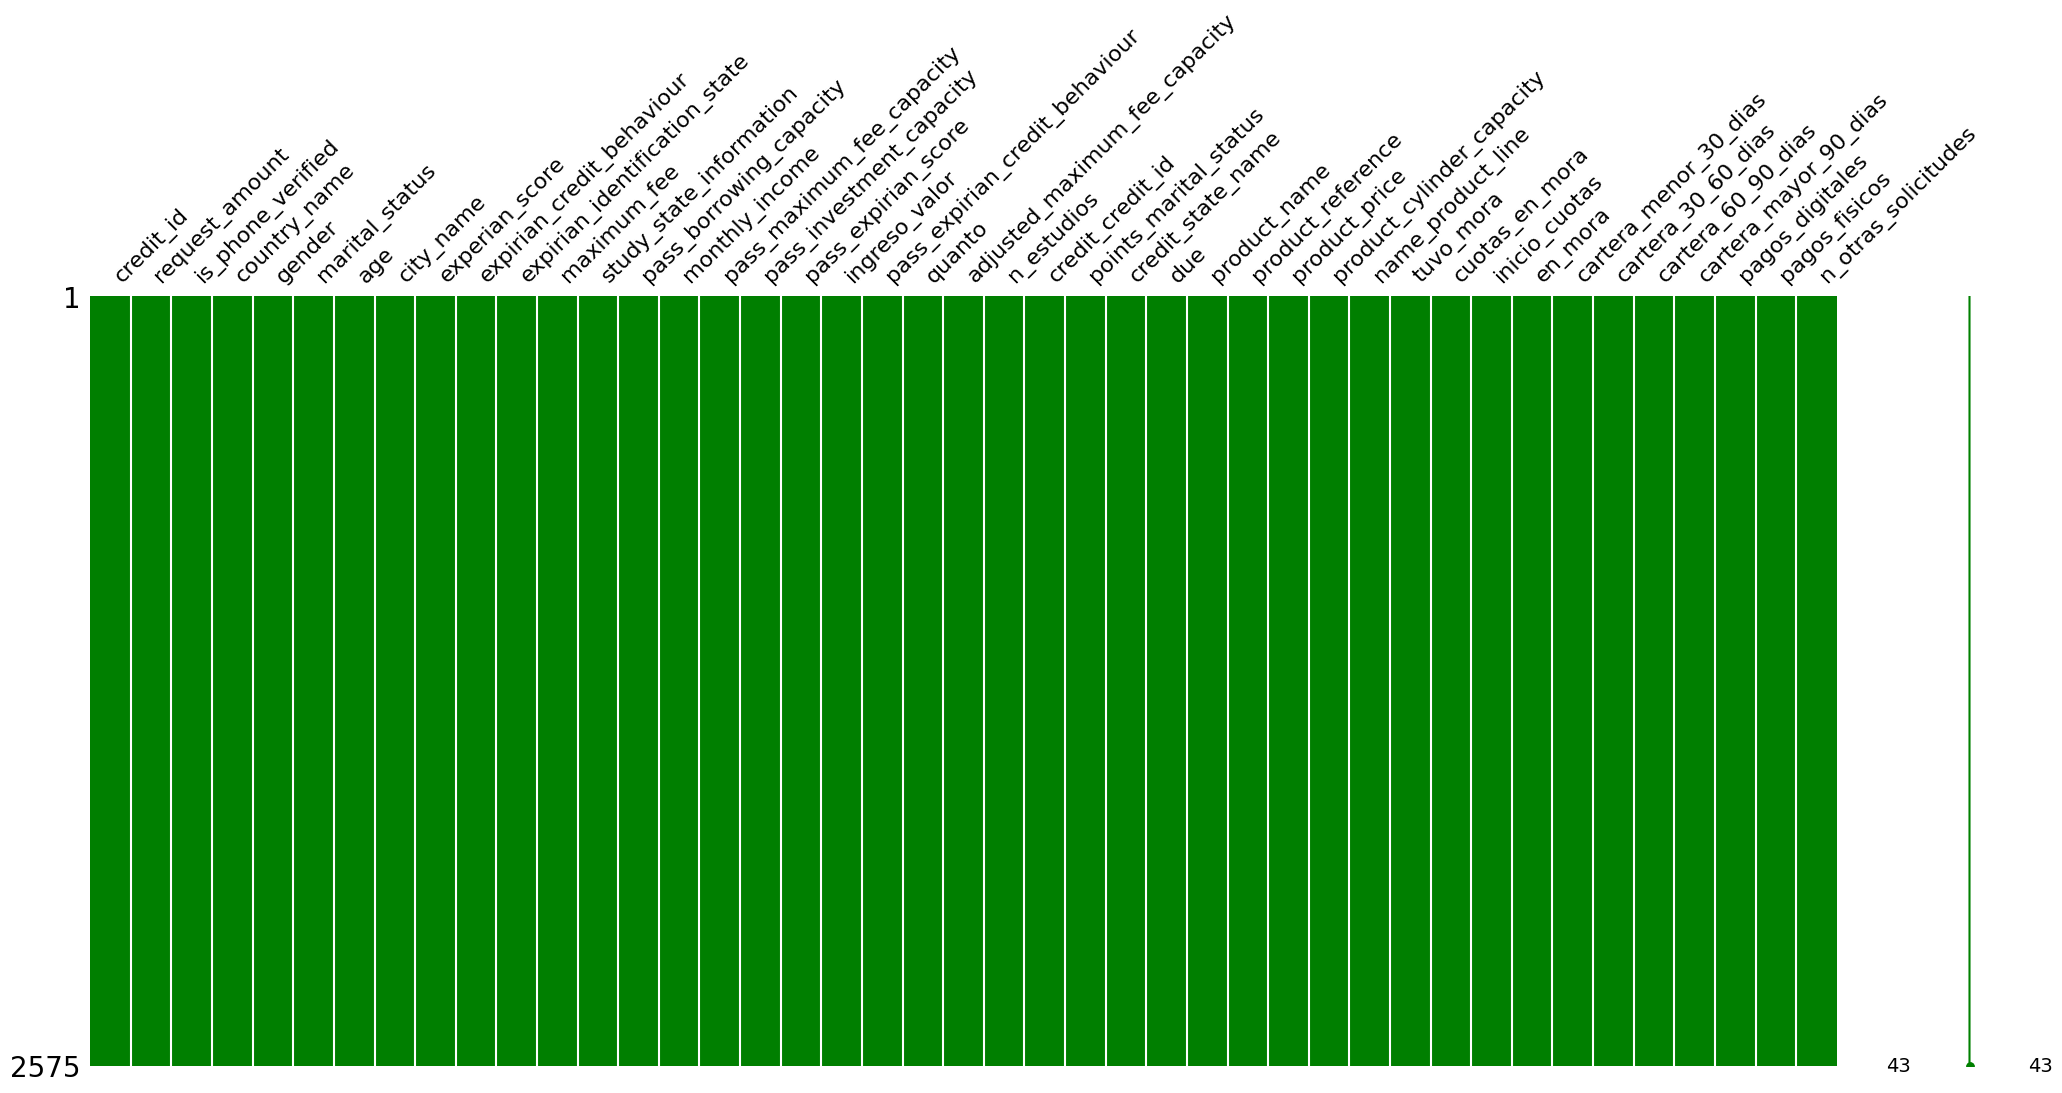

In [ ]:
msno.matrix(df, color=(0, 0.5, 0))
plt.show()

- Realizado la transformación de valores nulos, validamos nuevamente la información básica, estructura y contenido del dataframe.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2575 entries, 0 to 2574
Data columns (total 43 columns):
 #   Column                          Non-Null Count  Dtype               
---  ------                          --------------  -----               
 0   credit_id                       2575 non-null   Int64               
 1   request_amount                  2575 non-null   Float64             
 2   is_phone_verified               2575 non-null   Int64               
 3   country_name                    2575 non-null   string              
 4   gender                          2575 non-null   string              
 5   marital_status                  2575 non-null   string              
 6   age                             2575 non-null   Int64               
 7   city_name                       2575 non-null   string              
 8   experian_score                  2575 non-null   Int64               
 9   expirian_credit_behaviour       2575 non-null   string              
 10  expir

- A continuación identificamos y clasificamos las columnas del DataFrame (df) en dos tipos: categóricas y numéricas.

In [ ]:
category_columns = df.select_dtypes(include=["string","object"]).columns
numeric_columns = df.select_dtypes(include=['Int64','Float64']).columns
print('Columnas Categóricas: >>>>', category_columns)
print('Columnas Numéricas: >>>>>>',numeric_columns)

Columnas Categóricas: >>>> Index(['country_name', 'gender', 'marital_status', 'city_name',
       'expirian_credit_behaviour', 'expirian_identification_state',
       'study_state_information', 'credit_state_name', 'product_name',
       'product_reference', 'name_product_line'],
      dtype='object')
Columnas Numéricas: >>>>>> Index(['credit_id', 'request_amount', 'is_phone_verified', 'age',
       'experian_score', 'maximum_fee', 'pass_borrowing_capacity',
       'monthly_income', 'pass_maximum_fee_capacity',
       'pass_investment_capacity', 'pass_expirian_score', 'ingreso_valor',
       'pass_expirian_credit_behaviour', 'quanto',
       'adjusted_maximum_fee_capacity', 'n_estudios', 'credit_credit_id',
       'points_marital_status', 'due', 'product_price',
       'product_cylinder_capacity', 'tuvo_mora', 'cuotas_en_mora', 'en_mora',
       'cartera_menor_30_dias', 'cartera_30_60_dias', 'cartera_60_90_dias',
       'cartera_mayor_90_dias', 'pagos_digitales', 'pagos_fisicos',
     

- Procedemos a recorrer todas las columnas categóricas (de tipo string), agrupando los datos por los valores únicos de cada columna y cuenta cuántas veces aparece cada valor, imprimiendo el resultado para cada columna categórica del DataFrame.

In [ ]:
from IPython.display import display, HTML


In [ ]:
for col in category_columns:
    columna_html = f'<b style="color:blue;">{col}</b>'
    display(HTML(f">>>>> Niveles de la variable {columna_html}:"))
    print(df.groupby(col).size())
    print("\n")

gender
HOMBRE       1651
MUJER         896
Pendiente      28
dtype: int64




city_name
Bello             5
Bogotá         2233
Cajicá            5
Cali             80
Chia             60
Cogua             1
Cota             10
Funza             4
Guasca            1
La Estrella       1
La calera         7
Madrid            8
Medellín         41
Mosquera         11
Sesquilé          2
Sibaté            3
Soacha           84
Sopó              2
Tabio             5
Tenjo             2
Tocancipá         4
Zipaquirá         2
gachancipá        4
dtype: int64




study_state_information
Aprobado                                       2239
Crédito aprobado con reajuste de parámetros     336
dtype: int64




name_product_line
AKT         99
BAJAJ     1867
HERO       124
SUZUKI     485
dtype: int64




- A continuación se filtra y modifica una lista de columnas categóricas, eliminando algunas columnas no deseadas y añadiendo otras relevantes para el análisis.

In [ ]:
columns_to_drop = ['country_name','expirian_identification_state','credit_state_name','expirian_credit_behaviour','product_name','product_reference', 'marital_status']
category_columns = [col for col in category_columns if col not in columns_to_drop]
category_columns1 = category_columns.copy()
category_columns1.extend(['product_name', 'product_reference'])
category_columns

['gender', 'city_name', 'study_state_information', 'name_product_line']

# 5. Visualización de Datos
Se generaron histogramas, gráficos de barras y boxplots para analizar la distribución y dispersión de los datos.

 - Seguidamente procederemos a visualizar las distribuciones de varias columnas categóricas en un solo conjunto de gráficos organizados en una cuadrícula. Para cada columna, se crea un gráfico de barras que muestra la frecuencia de los valores, y los gráficos se presentan de forma ordenada y estética

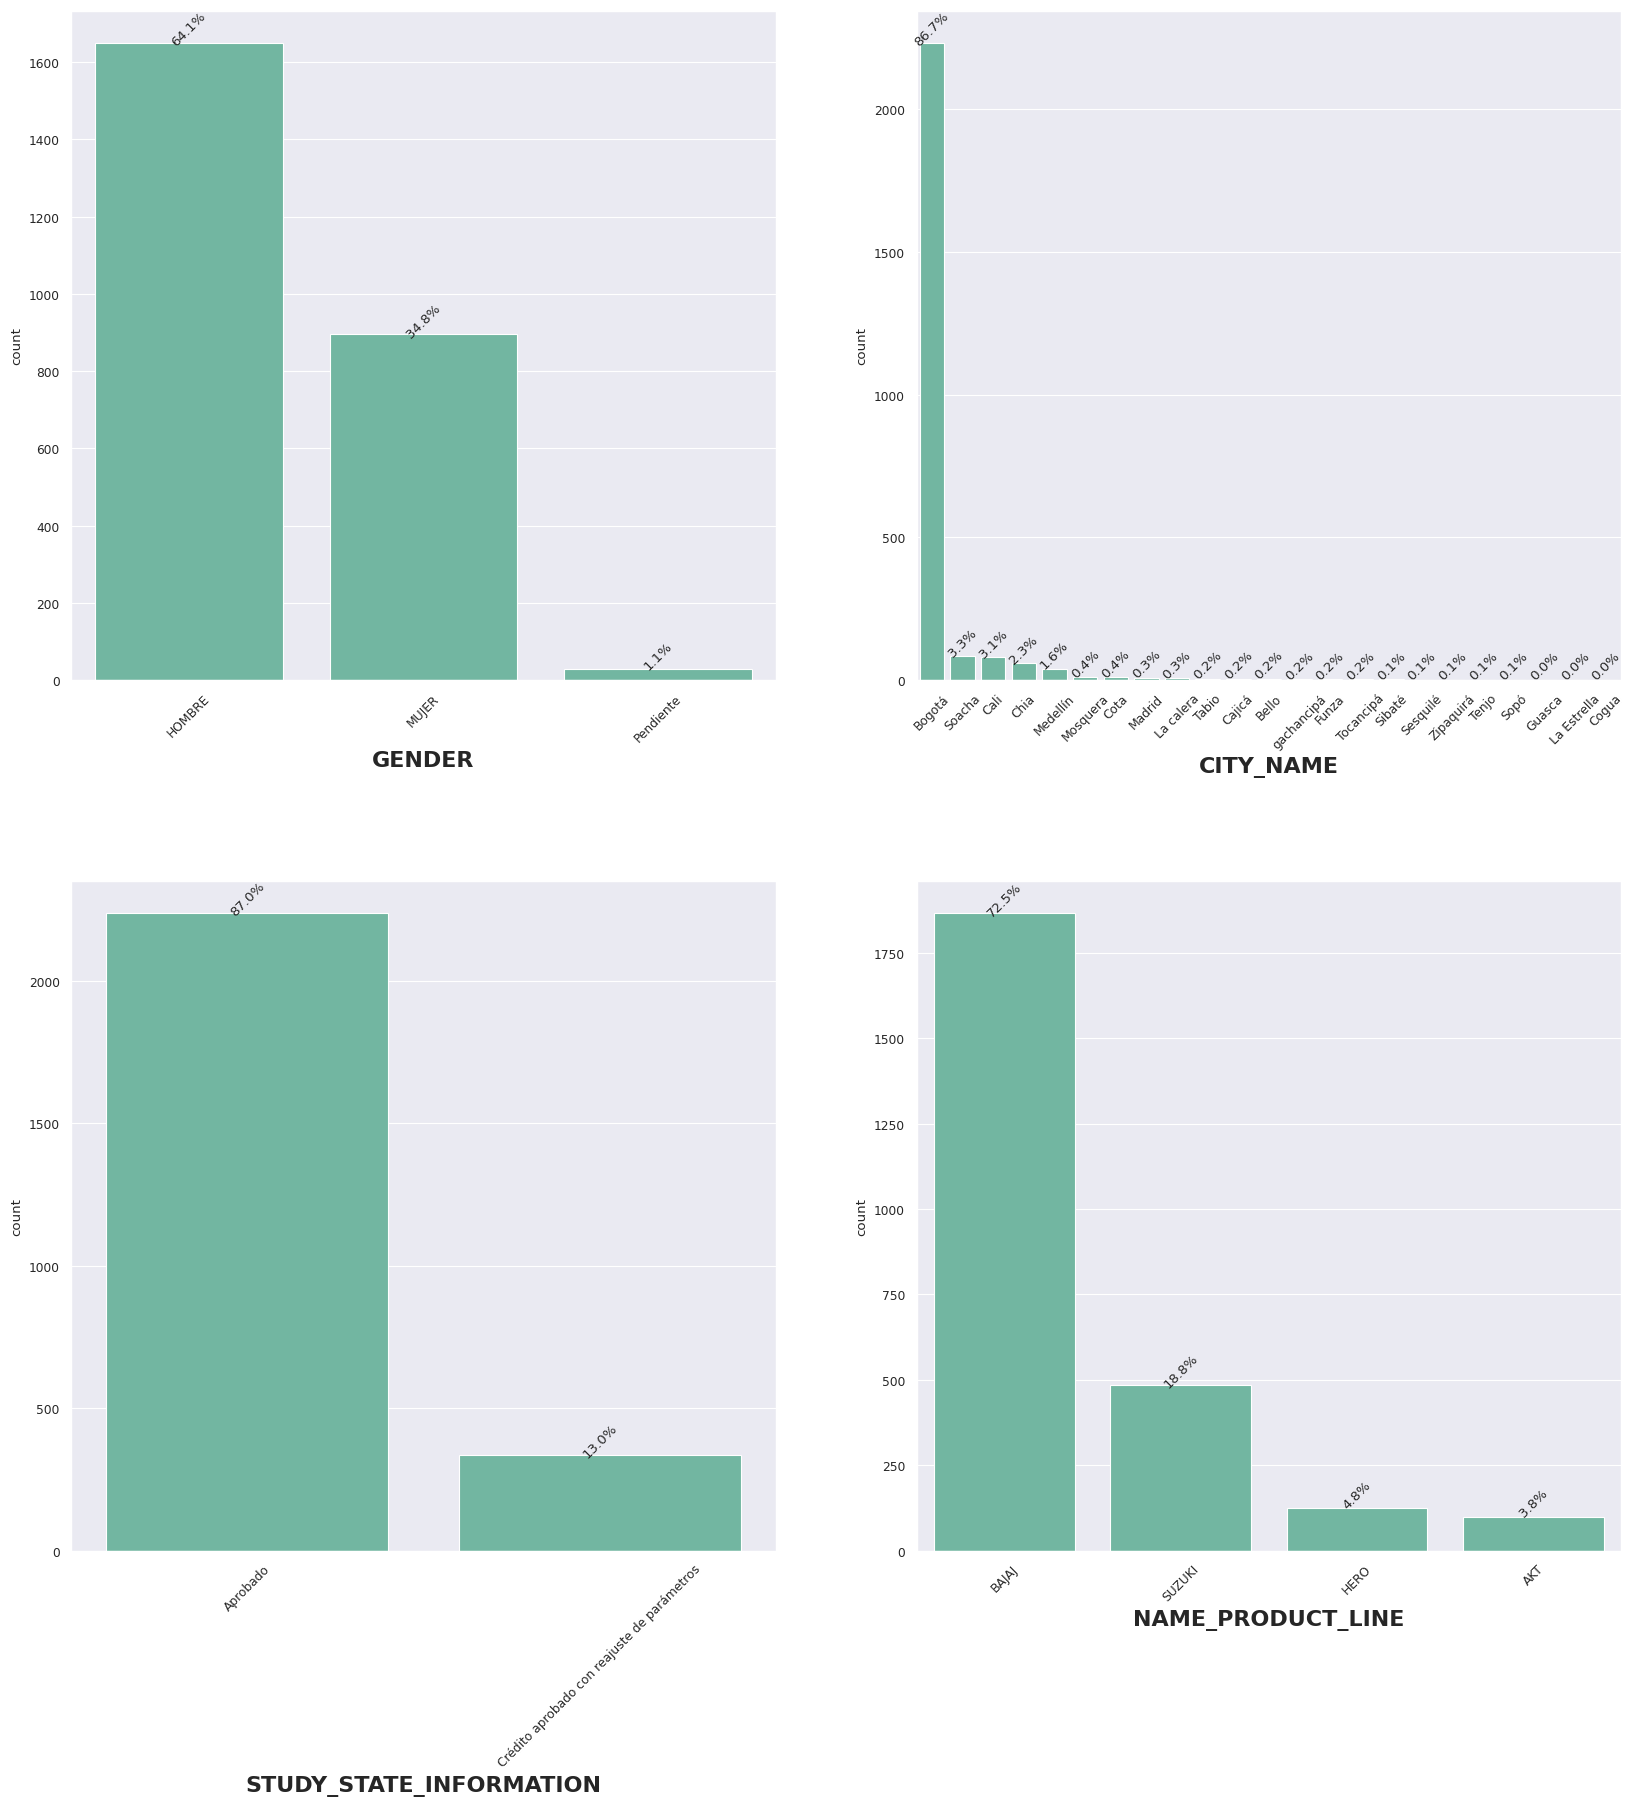

In [ ]:
fig = plt.figure(figsize=(20, 20))
fig.tight_layout()

# Limitar el número de subgráficos a 4 si hay más de 4 columnas
n_cols = 2
n_rows = 2
n_plots = min(len(category_columns1), n_cols * n_rows)

for i in range(n_plots):
    plt.subplot(n_rows, n_cols, 1 + i)  # Ajustar el índice para que no exceda 4
    sns.set_theme("paper", "darkgrid", sns.color_palette("Set2"))

    # Ordenar las barras de mayor a menor frecuencia
    order = df[category_columns1[i]].value_counts().index
    ax = sns.countplot(x=category_columns1[i], data=df, order=order)

    # Agregar etiquetas con el porcentaje y rotación de 45 grados
    total = len(df)
    for p in ax.patches:
        count = p.get_height()
        percentage = f'{100 * count / total:.1f}%'
        ax.annotate(f'{percentage}',
                    (p.get_x() + p.get_width() / 2., count),
                    ha='center', va='center',
                    xytext=(0, 10),
                    textcoords='offset points',
                    rotation=45)

    # Resaltar etiquetas del eje x en negrita y mayúsculas
    ax.set_xlabel(ax.get_xlabel().upper(), fontweight='bold', fontsize=16)
    plt.xticks(rotation=45)

plt.subplots_adjust(hspace=0.3)
plt.show()


- Identificamos y seleccionamos las columnas numéricas dentro de un dataframe para trabajar solo con datos numéricos.

In [ ]:
#profile.to_html()
numeric_columns = df.select_dtypes(include=['Int64','Float64']).columns
#numeric_columns = [column for column in numeric_columns if 'credit_id' not in column]
numeric_columns

Index(['credit_id', 'request_amount', 'is_phone_verified', 'age',
       'experian_score', 'maximum_fee', 'pass_borrowing_capacity',
       'monthly_income', 'pass_maximum_fee_capacity',
       'pass_investment_capacity', 'pass_expirian_score', 'ingreso_valor',
       'pass_expirian_credit_behaviour', 'quanto',
       'adjusted_maximum_fee_capacity', 'n_estudios', 'credit_credit_id',
       'points_marital_status', 'due', 'product_price',
       'product_cylinder_capacity', 'tuvo_mora', 'cuotas_en_mora', 'en_mora',
       'cartera_menor_30_dias', 'cartera_30_60_dias', 'cartera_60_90_dias',
       'cartera_mayor_90_dias', 'pagos_digitales', 'pagos_fisicos',
       'n_otras_solicitudes'],
      dtype='object')

- Procedemos a contar la frecuencia de los niveles o valores únicos en las columnas numéricas del DataFrame (df). Sin embargo, como las columnas numéricas no suelen tener "niveles" en el sentido tradicional (como las categóricas), este código agrupa los datos numéricos por cada valor único y luego cuenta cuántas veces aparece cada valor.

In [ ]:
for col in category_columns:
    columna_html = f'<b style="color:blue;">{col}</b>'
    display(HTML(f">>>>> Niveles de la variable {columna_html}:"))
    print(df.groupby(col).size())
    print("\n")

gender
HOMBRE       1651
MUJER         896
Pendiente      28
dtype: int64




city_name
Bello             5
Bogotá         2233
Cajicá            5
Cali             80
Chia             60
Cogua             1
Cota             10
Funza             4
Guasca            1
La Estrella       1
La calera         7
Madrid            8
Medellín         41
Mosquera         11
Sesquilé          2
Sibaté            3
Soacha           84
Sopó              2
Tabio             5
Tenjo             2
Tocancipá         4
Zipaquirá         2
gachancipá        4
dtype: int64




study_state_information
Aprobado                                       2239
Crédito aprobado con reajuste de parámetros     336
dtype: int64




name_product_line
AKT         99
BAJAJ     1867
HERO       124
SUZUKI     485
dtype: int64




In [ ]:
for col in numeric_columns:
    print(f"Conteo de niveles para la columna '{col}':")
    print(df.groupby(col).size())
    print("\n")

Conteo de niveles para la columna 'credit_id':
credit_id
72       1
74       1
131      1
135      1
181      1
        ..
39529    1
39533    1
39541    1
39865    1
39886    1
Length: 2574, dtype: int64


Conteo de niveles para la columna 'request_amount':
request_amount
1760000.0     1
2200000.0     1
2300000.0     1
2361100.0     1
2388000.0     1
             ..
19499000.0    2
19599000.0    2
19754000.0    1
19990000.0    1
20699000.0    1
Length: 904, dtype: int64


Conteo de niveles para la columna 'is_phone_verified':
is_phone_verified
1    2575
dtype: int64


Conteo de niveles para la columna 'age':
age
19      1
20      8
21    241
22    232
23    199
24    162
25    147
26    139
27    102
28     87
29     98
30     74
31     79
32     75
33     74
34     61
35     69
36     43
37     42
38     41
39     53
40     40
41     45
42     44
43     29
44     34
45     35
46     34
47     18
48     28
49     29
50     16
51     19
52     24
53     20
54     16
55     15
56     10

- Eliminamos las columnas numéricas irrelevantes de un conjunto de columnas y actualiza la lista numeric_columns para que contenga solo las columnas numéricas que se desean analizar o utilizar.

In [ ]:
columns_to_drop = ['credit_credit_id','is_phone_verified','pass_investment_capacity','pass_expirian_score','pass_expirian_credit_behaviour', 'pass_maximum_fee_capacity', 'points_marital_status']
numeric_columns = [col for col in numeric_columns if col not in columns_to_drop]
numeric_columns

['credit_id',
 'request_amount',
 'age',
 'experian_score',
 'maximum_fee',
 'pass_borrowing_capacity',
 'monthly_income',
 'ingreso_valor',
 'quanto',
 'adjusted_maximum_fee_capacity',
 'n_estudios',
 'due',
 'product_price',
 'product_cylinder_capacity',
 'tuvo_mora',
 'cuotas_en_mora',
 'en_mora',
 'cartera_menor_30_dias',
 'cartera_30_60_dias',
 'cartera_60_90_dias',
 'cartera_mayor_90_dias',
 'pagos_digitales',
 'pagos_fisicos',
 'n_otras_solicitudes']

- Procedemos a visualizar las distribuciones de las columnas numéricas dentro del DataFrame df utilizando histogramas. El código genera una serie de histogramas para cada columna numérica en numeric_columns, mostrando la frecuencia de los valores y ayudando a explorar la distribución de cada variable numérica

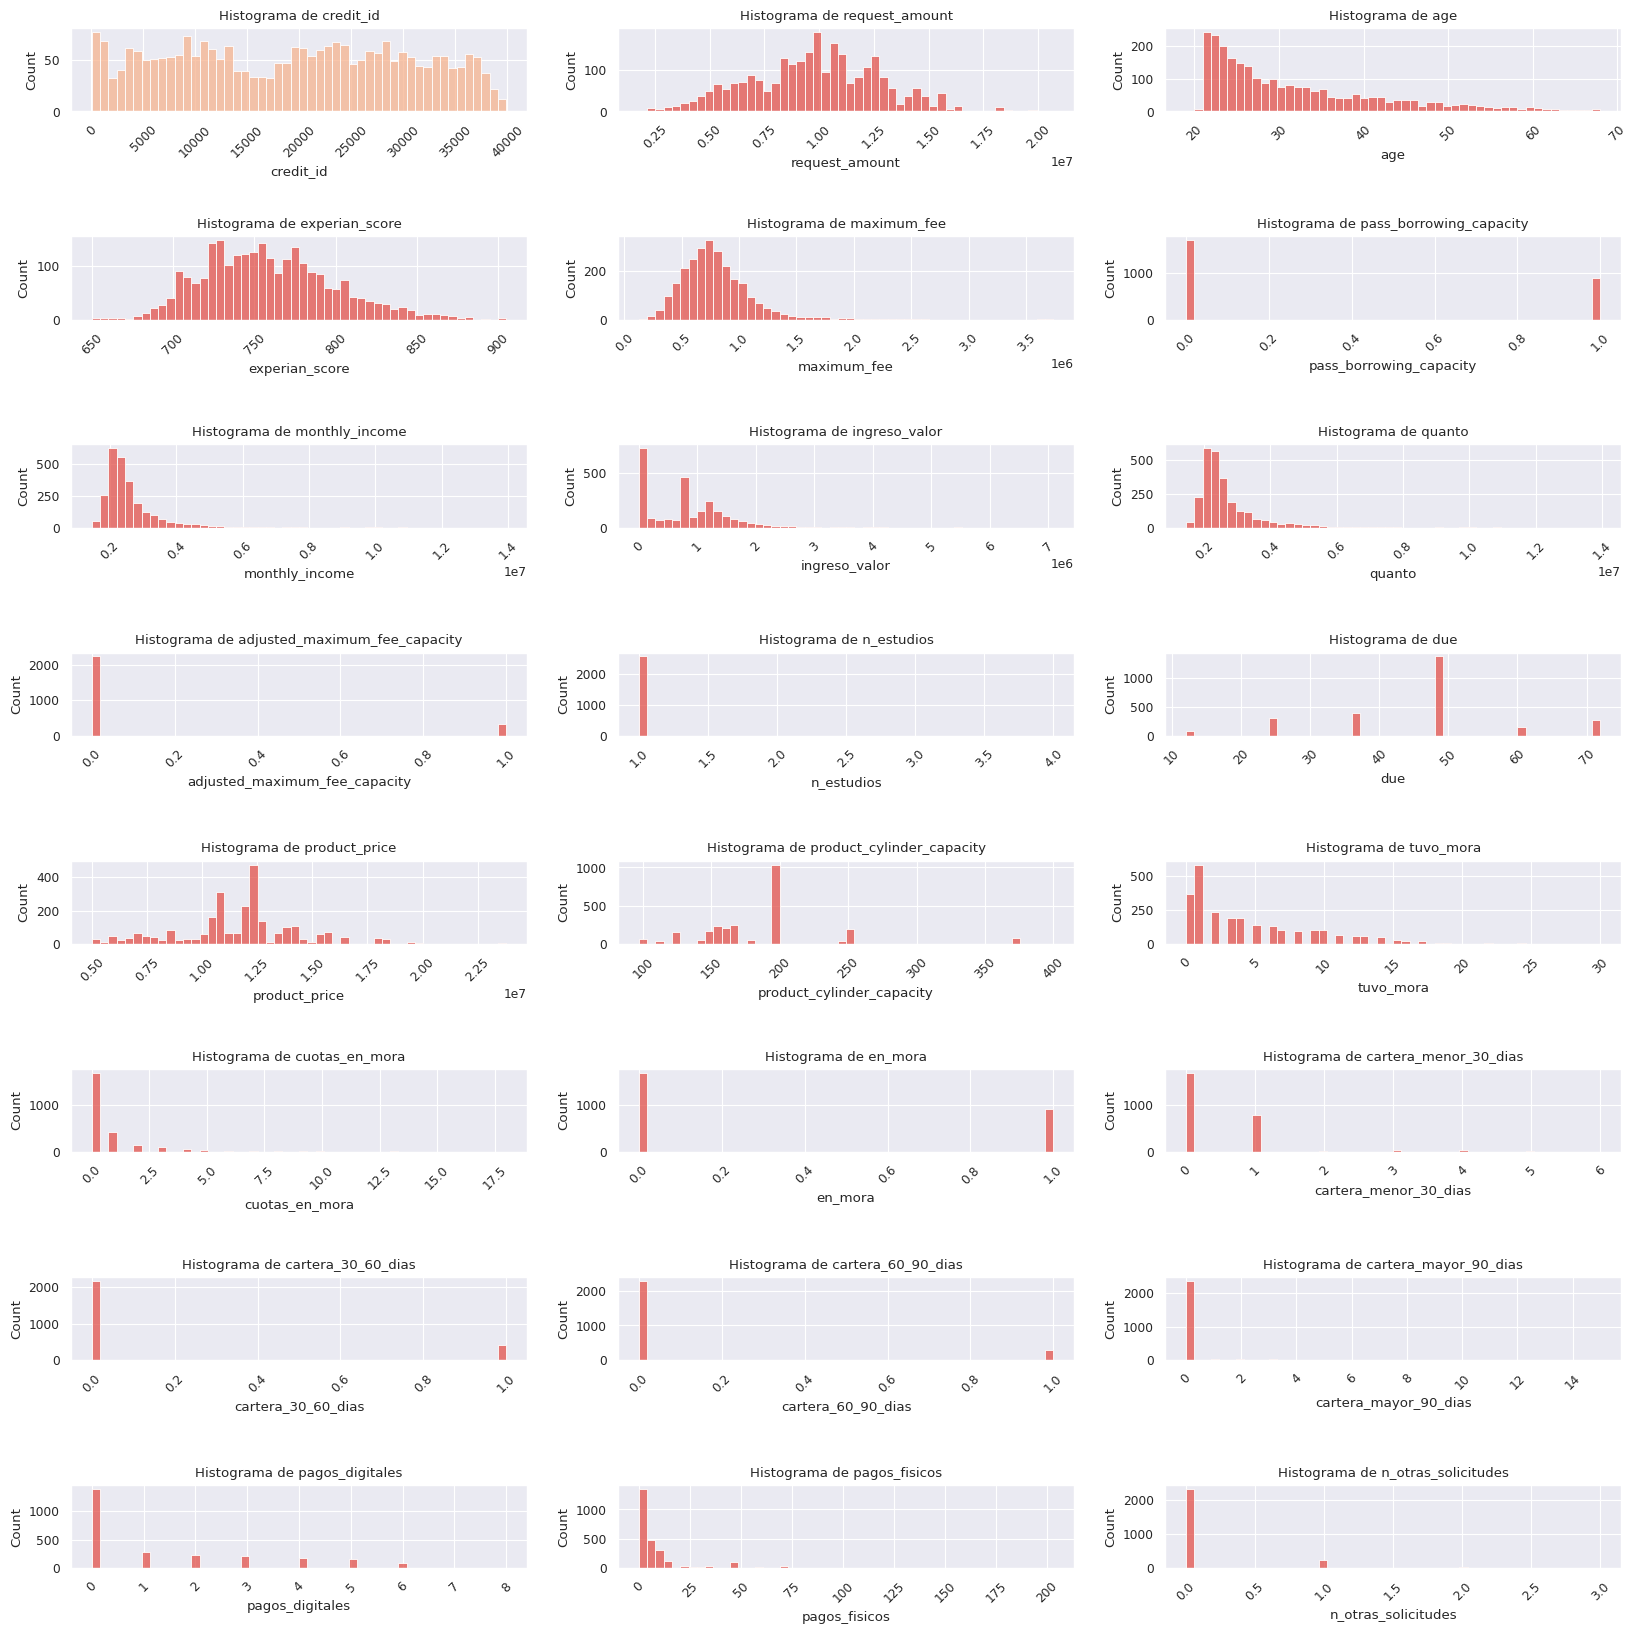

In [ ]:
fig = plt.figure(figsize=(20,20))
fig.tight_layout()
for i in range(len(numeric_columns)):
    plt.subplot(8,3,1+int(i))
    sns.set_theme("paper","darkgrid",sns.color_palette("Spectral"))
    sns.histplot(df[numeric_columns[i]],bins=50, kde=False)
    plt.xticks(rotation=45)
    plt.title(f'Histograma de {numeric_columns[i]}')
plt.subplots_adjust(hspace=1.5)
#plt.subplots_adjust(vspace=1.5)
plt.show()